In [1]:
import pickle
import numpy as np
with open("train_qa.txt","rb") as fp:
    train_data = pickle.load(fp)
with open("test_qa.txt","rb") as fp:
    test_data=pickle.load(fp)

In [2]:
vocab = set()
all_data = train_data + test_data
for story,question,answer in all_data :
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))
vocab.add('yes')
vocab.add('no')
vocab_len = len(vocab)+1
vocab_len

38

In [3]:
max_story_len = max([len(data[0]) for data in all_data])
max_ques_len = max([len(data[1]) for data in all_data]) 

In [4]:
from keras_preprocessing.sequence import pad_sequences
from keras_preprocessing.text import Tokenizer
tokenizer = Tokenizer(filters=[]) 
tokenizer.fit_on_texts(vocab)
tokenizer.word_index

{'bedroom': 1,
 'football': 2,
 '?': 3,
 'hallway': 4,
 'grabbed': 5,
 'left': 6,
 'sandra': 7,
 'back': 8,
 'got': 9,
 'apple': 10,
 'in': 11,
 'picked': 12,
 '.': 13,
 'moved': 14,
 'discarded': 15,
 'kitchen': 16,
 'up': 17,
 'journeyed': 18,
 'took': 19,
 'bathroom': 20,
 'travelled': 21,
 'daniel': 22,
 'is': 23,
 'john': 24,
 'garden': 25,
 'yes': 26,
 'dropped': 27,
 'no': 28,
 'there': 29,
 'went': 30,
 'milk': 31,
 'office': 32,
 'to': 33,
 'down': 34,
 'mary': 35,
 'put': 36,
 'the': 37}

In [27]:
train_story = []
train_question = [] 
train_answer = []
for story,question,answer in train_data:
    train_story.append(story)
    train_question.append(question) 

train_story_seq = tokenizer.texts_to_sequences(train_story)
# print(len(train_story))
train_story_seq

[[35, 14, 33, 37, 20, 13, 7, 18, 33, 37, 1, 13],
 [35,
  14,
  33,
  37,
  20,
  13,
  7,
  18,
  33,
  37,
  1,
  13,
  35,
  30,
  8,
  33,
  37,
  1,
  13,
  22,
  30,
  8,
  33,
  37,
  4,
  13],
 [35,
  14,
  33,
  37,
  20,
  13,
  7,
  18,
  33,
  37,
  1,
  13,
  35,
  30,
  8,
  33,
  37,
  1,
  13,
  22,
  30,
  8,
  33,
  37,
  4,
  13,
  7,
  30,
  33,
  37,
  16,
  13,
  22,
  30,
  8,
  33,
  37,
  20,
  13],
 [35,
  14,
  33,
  37,
  20,
  13,
  7,
  18,
  33,
  37,
  1,
  13,
  35,
  30,
  8,
  33,
  37,
  1,
  13,
  22,
  30,
  8,
  33,
  37,
  4,
  13,
  7,
  30,
  33,
  37,
  16,
  13,
  22,
  30,
  8,
  33,
  37,
  20,
  13,
  22,
  12,
  17,
  37,
  2,
  29,
  13,
  22,
  30,
  33,
  37,
  1,
  13],
 [35,
  14,
  33,
  37,
  20,
  13,
  7,
  18,
  33,
  37,
  1,
  13,
  35,
  30,
  8,
  33,
  37,
  1,
  13,
  22,
  30,
  8,
  33,
  37,
  4,
  13,
  7,
  30,
  33,
  37,
  16,
  13,
  22,
  30,
  8,
  33,
  37,
  20,
  13,
  22,
  12,
  17,
  37,
  2,
  29,
  13,
  2

In [28]:
def vectorize_stories(data,word_index = tokenizer.word_index,
                      max_story_len = max_story_len,max_ques_len = max_ques_len): 

    X = [] #stories 
    Xq = [] #query/question 
    Y = [] #correct answer  

    for story,query,answer in data :
        x = [word_index[word.lower()] for word in story]
        xq = [word_index[word.lower()] for word in query] 
        y = np.zeros(len(word_index)+1) 
        y[word_index[answer]]=1 
    
        X.append(x) 
        Xq.append(xq) 
        Y.append(y) 
        
    return(pad_sequences(X,maxlen = max_story_len),
           pad_sequences(X,maxlen = max_ques_len),
           np.array(Y))

In [29]:
inputs_train,queries_train,answers_train = vectorize_stories(train_data)
inputs_test,queries_test,answers_test = vectorize_stories(test_data)

In [30]:
import keras.models as km
import keras.layers as kle
import keras.layers as kl
from keras.models import Sequential,Model

input_sequence = kl.Input((max_story_len,))
question = kl.Input((max_ques_len,))
#Input Encoders m
input_encoder_m = Sequential()
input_encoder_m.add(kle.Embedding(input_dim = vocab_len,output_dim=64))
input_encoder_m.add(kl.Dropout(0.3))
#Input Encoders c
input_encoder_c= km.Sequential()
input_encoder_c.add(kle.Embedding(input_dim = vocab_len,output_dim=max_ques_len))
input_encoder_c.add(kl.Dropout(0.3))
#Question Encoder 
question_encoder = km.Sequential()
question_encoder.add(kle.Embedding(input_dim = vocab_len,output_dim = 64,input_length = max_ques_len))
question_encoder.add(kl.Dropout(0.3))
#Encode the sequences
question_encoder = km.Sequential()
question_encoder.add(kle.Embedding(input_dim = vocab_len,output_dim = 64,input_length = max_ques_len))
question_encoder.add(kl.Dropout(0.3))

input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

match = kl.dot([input_encoded_m,question_encoded],axes = (2,2))
match = kl.Activation('softmax')(match)
response = kl.add([match,input_encoded_c])
response = kl.Permute((2,1))(response)
#concatenate
answer = kl.concatenate([response,question_encoded])
answer

<KerasTensor: shape=(None, 6, 220) dtype=float32 (created by layer 'concatenate_2')>

In [13]:
answer = kl.LSTM(32)(answer)
answer = kl.Dropout(0.5)(answer)
answer = kl.Dense(vocab_len)(answer)
answer = kl.Activation('softmax')(answer)
model = km.Model([input_sequence,question],answer)
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 156)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 6)]                  0         []                            
                                                                                                  
 sequential (Sequential)     (None, None, 64)             2432      ['input_1[0][0]']             
                                                                                                  
 sequential_3 (Sequential)   (None, 6, 64)                2432      ['input_2[0][0]']             
                                                                                              

In [14]:
history = model.fit([inputs_train,queries_train],answers_train,
                    batch_size=32,epochs=20,validation_data=([inputs_test,queries_test],answers_test))

Epoch 1/20
313/313 [==============================] - 8s 14ms/step - loss: 0.8856 - accuracy: 0.4958 - val_loss: 0.6963 - val_accuracy: 0.4970
Epoch 2/20
313/313 [==============================] - 4s 12ms/step - loss: 0.7054 - accuracy: 0.4976 - val_loss: 0.6936 - val_accuracy: 0.5030
Epoch 3/20
313/313 [==============================] - 4s 14ms/step - loss: 0.6978 - accuracy: 0.4985 - val_loss: 0.6943 - val_accuracy: 0.4970
Epoch 4/20
313/313 [==============================] - 5s 17ms/step - loss: 0.6959 - accuracy: 0.5054 - val_loss: 0.6947 - val_accuracy: 0.4970
Epoch 5/20
313/313 [==============================] - 5s 17ms/step - loss: 0.6953 - accuracy: 0.5051 - val_loss: 0.6937 - val_accuracy: 0.5030
Epoch 6/20
313/313 [==============================] - 7s 23ms/step - loss: 0.6954 - accuracy: 0.5003 - val_loss: 0.6948 - val_accuracy: 0.4970
Epoch 7/20
313/313 [==============================] - 6s 18ms/step - loss: 0.6957 - accuracy: 0.4991 - val_loss: 0.6931 - val_accuracy: 0.5030

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Text(0.5, 0, 'epochs')

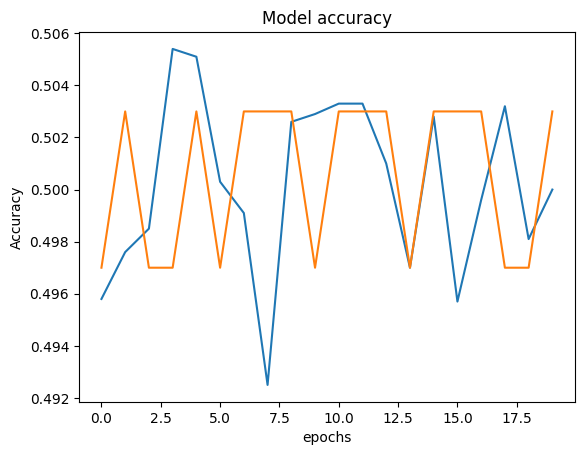

In [15]:
import matplotlib.pyplot as plt
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("epochs")

In [16]:
#save the model 
model.save("latest_chatbot")

INFO:tensorflow:Assets written to: latest_chatbot\assets


INFO:tensorflow:Assets written to: latest_chatbot\assets


In [17]:
model.load_weights("latest_chatbot")

In [18]:
predict_result = model.predict(([inputs_test,queries_test]))
story = ' '.join(word for word in test_data[0][0])
print(story)
query = ' '.join(word for word in test_data[0][1])
print(query)
print(test_data[0][2])

32/32 [==============================] - 1s 8ms/step
Mary got the milk there . John moved to the bedroom .
Is John in the kitchen ?
no


In [19]:
story = ' '.join(word for word in test_data[15][0])
print(story)
query = ' '.join(word for word in test_data[15][1])
print(query)
print(test_data[15][2])

John journeyed to the hallway . John got the apple there .
Is John in the hallway ?
yes


In [21]:
val_max = np.argmax(predict_result[15])
for key,val in tokenizer.word_index.items():
    if val == val_max:
        k = key
if(k=='yes'):
	k='no'
else:
    k='yes'
print("Predicted answer is ",k)
print("Probability of certainity ",predict_result[15][val_max])

Predicted answer is  yes
Probability of certainity  0.5030614


In [22]:
story = 'Mary dropped the football . Sandra discarded apple in kitchen .'
story.split()
my_question = "is apple in the kitchen ? "
mydata = [(story.split(),my_question.split(),'yes')]
my_story, my_ques, my_ans = vectorize_stories(mydata)
predict_result = model.predict(([my_story,my_ques]))

val_max = np.argmax(predict_result[0])
for key,val in tokenizer.word_index.items():
    if val == val_max:
        k = key
if(k=='yes'):
	k='no'
else:
    k='yes'        
print("Predicted answer is ",k)
print("Probability of certainity ",predict_result[0][val_max])

1/1 [==============================] - 0s 51ms/step
Predicted answer is  yes
Probability of certainity  0.50304496


In [23]:
story = 'Mary dropped the football . Sandra discarded apple in kitchen . Daniel went to office .'
story.split()
my_question = "Is Daniel in kitchen ?"
mydata = [(story.split(),my_question.split(),'yes')]
my_story, my_ques, my_ans = vectorize_stories(mydata)
predict_result = model.predict(([my_story,my_ques]))

val_max = np.argmax(predict_result[0])
for key,val in tokenizer.word_index.items():
    if val == val_max:
        k = key
if(k=='yes'):
	k='no'
else:
    k='yes'
print("Predicted answer is ",k)
print("Probability of certainity ",predict_result[0][val_max])

1/1 [==============================] - 0s 36ms/step
Predicted answer is  yes
Probability of certainity  0.5029931


In [24]:
story = 'mary went to garden . John put apple in kitchen .'
story.split()
my_question = "Is apple in kitchen ?"
mydata = [(story.split(),my_question.split(),'yes')]
my_story, my_ques, my_ans = vectorize_stories(mydata)
predict_result = model.predict(([my_story,my_ques]))

val_max = np.argmax(predict_result[0])
for key,val in tokenizer.word_index.items():
    if val == val_max:
        k = key
if(k=='yes'):
	k='no'
else:
    k='yes'
print("Predicted answer is ",k)
print("Probability of certainity ",predict_result[0][val_max])

1/1 [==============================] - 0s 34ms/step
Predicted answer is  yes
Probability of certainity  0.50303876


In [25]:
story = 'mary dropped the football . Sandra discarded apple in kitchen .'
story.split()
my_question = "Is apple in kitchen ?"
mydata = [(story.split(),my_question.split(),'no')]
my_story, my_ques, my_ans = vectorize_stories(mydata)
predict_result = model.predict(([my_story,my_ques]))

val_max = np.argmax(predict_result[0])
for key,val in tokenizer.word_index.items():
    if val == val_max:
        k = key
if(k=='yes'):
	k='no'
else:
    k='yes'
print("Predicted answer is ",k)
print("Probability of certainity ",predict_result[0][val_max])

1/1 [==============================] - 0s 40ms/step
Predicted answer is  yes
Probability of certainity  0.50304496
